# 무신사 스냅 이미지를 이용한 패션 스타일 분류

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/스타일

/content/drive/MyDrive/스타일


In [ ]:
ls

포멀/  댄디/  스포츠/  스트릿/  걸리시/  캐주얼/  로맨틱/  output/


In [ ]:
# 클래스 이름(스타일 종류)
class_names = ['걸리시', '댄디', '로맨틱', '스트릿', '스포츠',  '캐주얼', '포멀']

걸리시 / 1897 / 12.606%
댄디 / 1838 / 12.214%
로맨틱 / 847 / 5.629%
스트릿 / 3846 / 25.558%
스포츠 / 869 / 5.775%
캐주얼 / 3796 / 25.226%
포멀 / 1955 / 12.992%


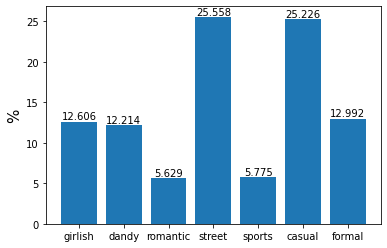

In [ ]:
# 스타일별 이미지 개수 비율(%)
style_count = []
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/스타일", folder_name)
    count = 0
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)                                # ex) 스타일/댄디_100.jpg
        count += 1
    style_count.append(count)
  
style_ratio = list(map(lambda x : round(x / sum(style_count) * 100, 3), style_count))

# 시각화
x = np.arange(7)
plt.bar(x, style_ratio)
plt.xticks(x,["girlish", 'dandy', 'romantic', 'street', 'sports', 'casual', 'formal'])
plt.ylabel('%', fontsize=15)
for i, v in enumerate(x):
    plt.text(v, style_ratio[i], style_ratio[i], fontsize = 10, color='black',
             horizontalalignment='center', verticalalignment='bottom') 
    print(f"{class_names[i]} / {style_count[i]} / {style_ratio[i]}%")
plt.show()

In [ ]:
!pip install split-folders

In [ ]:
# train / test 파일 나누기
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/스타일", output="output", seed=2, ratio=(0.75, 0.15,  0.1))

Copying files: 15047 files [06:15, 40.09 files/s] 


In [5]:
# train / val / test 데이터
train_path = '/content/drive/MyDrive/스타일/output/train'
val_path = '/content/drive/MyDrive/스타일/output/val'
test_path = '/content/drive/MyDrive/스타일/output/test'

In [ ]:
batch_size=64
image_size=(256, 256)

In [ ]:
seed = tf.random.set_seed(2)

# train / val / test 데이터셋
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode="categorical",
    class_names=class_names,
    shuffle=True,
    image_size=image_size,
    seed=seed,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    label_mode="categorical",
    class_names=class_names,
    shuffle=True,
    image_size=image_size,
    seed=seed,
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode="categorical",
    class_names=class_names,
    shuffle=True,
    image_size=image_size,
    seed=seed,
    batch_size=batch_size)

Found 15794 files belonging to 7 classes.
Found 2254 files belonging to 7 classes.
Found 1510 files belonging to 7 classes.


In [ ]:
# JPEG파일이 아닌 이미지 파일 확인

num_skipped = 0
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/스타일", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)                                # 스타일/캐주얼_1.jpg
        try:
            fobj = open(fpath, "rb")
            is_JPEG = tf.compat.as_bytes("jpeg") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_JPEG:
            num_skipped += 1

print(f"{num_skipped} images")

0 images


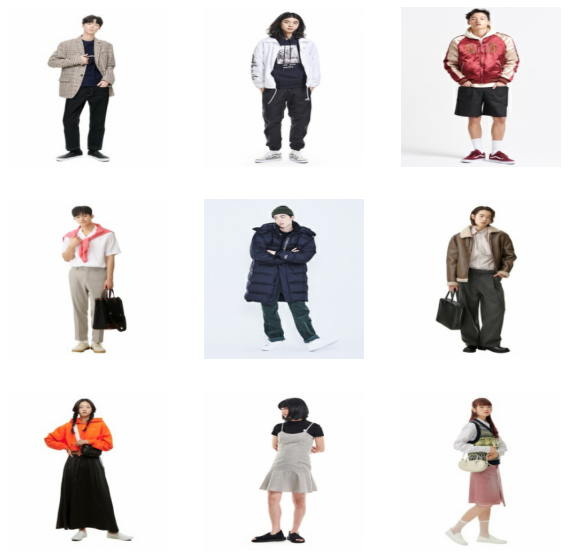

In [ ]:
# 이미지 예시
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### 이미지 데이터 수 증가

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

def image_augmentation(style, count):
  # train 데이터셋만 증강
  img = Augmentor.Pipeline(f'/content/drive/MyDrive/스타일/output/train/{style}')

  # 좌우 반전
  img.flip_left_right(probability=1.0)                             
                                                                              
  #회전
  img.rotate(probability=1, max_left_rotation=10, max_right_rotation=10)

  #랜덤 지우기
  img.random_erasing(probability=0.7, rectangle_area=0.3)

  # 증강할 이미지 개수
  img.sample(int(count * 0.3))      # 30% 증강

In [ ]:
# 스타일별로 증강
for style, count in zip(class_names, style_count):
  image_augmentation(style, count)

Initialised with 1422 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/걸리시/output.

Processing <PIL.Image.Image image mode=RGB size=220x330 at 0x7FAF266E5AD0>: 100%|██████████| 569/569 [00:06<00:00, 85.64 Samples/s] 


Initialised with 1378 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/댄디/output.

Processing <PIL.Image.Image image mode=RGB size=235x330 at 0x7FAF265A0B90>: 100%|██████████| 551/551 [00:06<00:00, 89.14 Samples/s]


Initialised with 635 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/로맨틱/output.

Processing <PIL.Image.Image image mode=RGB size=235x330 at 0x7FAFA6D82B90>: 100%|██████████| 254/254 [00:02<00:00, 85.58 Samples/s]


Initialised with 2884 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/스트릿/output.

Processing <PIL.Image.Image image mode=RGB size=220x330 at 0x7FAFA9059050>: 100%|██████████| 1153/1153 [00:13<00:00, 86.82 Samples/s]


Initialised with 651 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/스포츠/output.

Processing <PIL.Image.Image image mode=RGB size=236x330 at 0x7FAFA8A7AAD0>: 100%|██████████| 260/260 [00:02<00:00, 87.38 Samples/s]


Initialised with 2847 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/캐주얼/output.

Processing <PIL.Image.Image image mode=RGB size=235x330 at 0x7FAFA6D6BFD0>: 100%|██████████| 1138/1138 [00:13<00:00, 81.89 Samples/s]


Initialised with 1466 image(s) found.
Output directory set to /content/drive/MyDrive/스타일/output/train/포멀/output.

Processing <PIL.Image.Image image mode=RGB size=235x330 at 0x7FAFA8B90650>: 100%|██████████| 586/586 [00:06<00:00, 87.87 Samples/s]


In [ ]:
plus_image = []
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/스타일/output/train/", folder_name, 'output')
    count = 0
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)                                
        count += 1
    plus_image.append(count)

print("원본 데이터수", style_count)
print("추가된 데이터수", plus_image)

원본 데이터수 [1897, 1838, 847, 3846, 869, 3796, 1955]
추가된 데이터수 [569, 551, 254, 1153, 260, 1138, 586]


## 데이터 증강


In [ ]:
from tensorflow.keras import Sequential, Input, layers

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

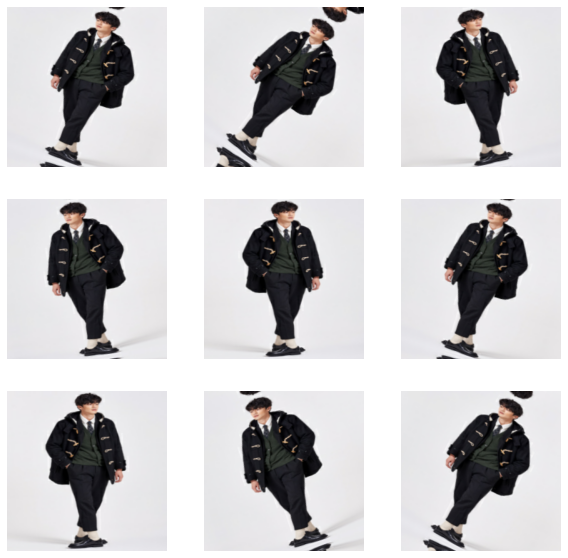

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# 훈련 데이터에 적용
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

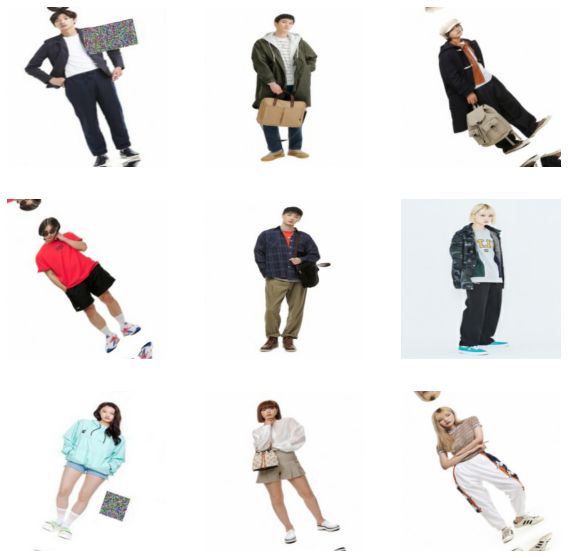

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        plt.axis("off")

## 모델링

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential

In [ ]:
# accuracy 그래프
def acc_graph(history):  
  acc = history.history['accuracy']                                             # loss = history.history['loss']
  val_acc = history.history['val_accuracy']                                     # val_loss = history.history['val_loss']
 
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Train Accuracy')
  plt.plot(val_acc, label='Val Accuracy')
  plt.text(len(acc)-2, val_acc[-1], f'{val_acc[-1]:.4f}')   # 최종 acc
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())+0.05])       # [최소, 최대]
  plt.title('Train and Val Accuracy')

In [ ]:
def train_model(model, train_X, val_X, batch_size, epochs):
  model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics='accuracy')

  # early stopping 설정
  #early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.02)

  hist = model.fit(train_X, validation_data=val_X, batch_size=batch_size, epochs=epochs)          # callbacks=[early]   
  return hist

In [ ]:
# 기본적인 CNN모델
def CNN_model(num_classes=7, input_shape=(256, 256, 3)):
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(layers.experimental.preprocessing.Rescaling(1./255))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPool2D())
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPool2D())
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax')) 

  return model

CNN_model1 = CNN_model()
CNN_model2 = CNN_model()

In [ ]:
CNN_hist1 = train_model(CNN_model1, train_ds, val_ds, 64, 50)       # 0.4676

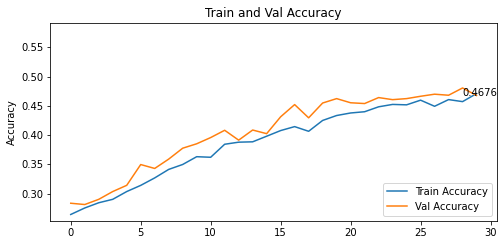

In [ ]:
acc_graph(CNN_hist1)

In [ ]:
CNN_model1.evaluate(test_ds)

24/24 [==============================] - 2s 64ms/step - loss: 1.3844 - accuracy: 0.4576


[1.384368658065796, 0.4576158821582794]

In [ ]:
CNN_hist2 = train_model(CNN_model2, augmented_train_ds, val_ds, 64, 30)   # 증강  0.4246

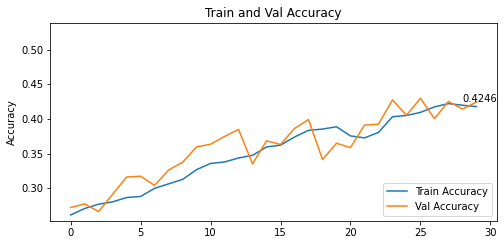

In [ ]:
acc_graph(CNN_hist2)

In [ ]:
CNN_model2.evaluate(test_ds)

24/24 [==============================] - 2s 64ms/step - loss: 1.4816 - accuracy: 0.4272


[1.4816123247146606, 0.4271523058414459]

## VGG-16 모델(tensorflow)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
def VGG_model(num_classes=7, input_shape=(256,256,3)):
  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

  vgg_model.trainable=False

  model = Sequential([
                      layers.experimental.preprocessing.Rescaling(1./255),
                      vgg_model,
                      layers.GlobalAveragePooling2D(),
                      layers.Dense(512, activation='relu'),
                      layers.Dropout(0.3),
                      layers.Dense(num_classes, activation='softmax')
  ])
  return model

vgg_model1 = VGG_model()

In [ ]:
vgg_hist1 = train_model(vgg_model1, train_ds, val_ds, 64, 30)

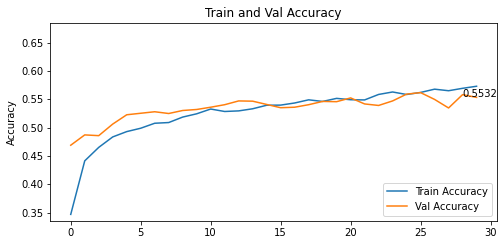

In [ ]:
acc_graph(vgg_hist1)

In [ ]:
vgg_model1.evaluate(test_ds)

24/24 [==============================] - 5s 196ms/step - loss: 1.1740 - accuracy: 0.5245


[1.1740145683288574, 0.5245032906532288]

## ResNet 모델(tensorflow)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

### ex1

In [ ]:
def load_transfer_model():
  base_model = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
      
  base_model.trainable = False

  transfer_model = Sequential([
                               layers.experimental.preprocessing.Rescaling(1./255),
                               base_model,
                               layers.GlobalAveragePooling2D(),
                               layers.Dense(256, activation='relu'),
                               layers.Dropout(0.3),
                               layers.Dense(7, activation='softmax')
  ])
  return transfer_model

transfer_model = load_transfer_model()

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

transfer_model.fit(normalized_train_ds, batch_size=32, validation_data=normalized_val_ds, epochs=20)   

### ex2

In [ ]:
# ResNet 모델
def ResNet50_model(num_classes=7, input_shape=(256,256,3)):
  # ImageNet으로 학습된 ResNet-50 모델
  resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)    # include_top=False 가장 마지막의 classification layer는 포함하지 않는다

  # 불러온 ResNet50 모델의 모든 layer를 freeze(학습 가능하지 않게 설정)
  resnet.trainable = False                                                      # for layer in resnet.layers:
                                                                                #     layer.trainable = False         
  x = resnet.output                                       
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.2)(x)
  outputs = Dense(num_classes, activation='softmax')(x) # 출력층

  model = Model(resnet.inputs,
                      outputs)
  return model

ResNet_model1 = ResNet50_model()
ResNet_model2 = ResNet50_model()

In [ ]:
resnet_hist1 = train_model(ResNet_model1, train_ds, val_ds, 64, 30)      # 0.5648

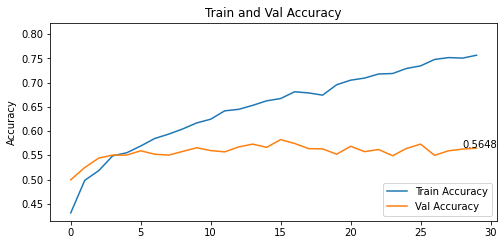

In [ ]:
acc_graph(resnet_hist1)

In [ ]:
ResNet_model1.evaluate(test_ds)

24/24 [==============================] - 158s 7s/step - loss: 1.2955 - accuracy: 0.5430


[1.2954727411270142, 0.5430463552474976]

In [ ]:
resnet_hist2 = train_model(ResNet_model2, augmented_train_ds, val_ds, 64, 30)  # 증강

In [ ]:
acc_graph(resnet_hist2)

In [ ]:
ResNet_model2.evaluate(test_ds)

93/93 [==============================] - 8s 78ms/step - loss: 1.2375 - accuracy: 0.5368


[1.23745596408844, 0.5367746353149414]

In [ ]:
from keras.models import load_model

# ResNet_model.save('ResNet_model.h5')
# ResNet_model = load_model('/content/ResNet_model.h5')

## EfficientNetB0

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

def EfficientNetB0_model(num_classes=7, input_shape=(256,256,3)):

  effi_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

  effi_model.trainable=False

  model = Sequential([                                                          # EfficientNet 모델은 1./255 scaling이 포함되어 있음
                      effi_model,
                      layers.GlobalAveragePooling2D(),
                      layers.Dense(256, activation='relu'),
                      layers.Dropout(0.3),
                      layers.Dense(num_classes, activation='softmax')
  ])

  return model

effiB0_model1 = EfficientNetB0_model()
effiB0_model2 = EfficientNetB0_model()

In [ ]:
effi_hist1 = train_model(effiB0_model1, train_ds, val_ds, 64, 20)

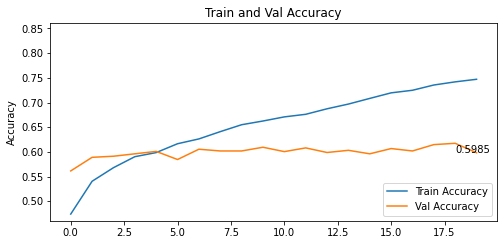

In [ ]:
acc_graph(effi_hist1)

In [ ]:
effiB0_model.evaluate(test_ds)

24/24 [==============================] - 3s 119ms/step - loss: 1.0764 - accuracy: 0.5921


[1.0764251947402954, 0.5920529961585999]

In [ ]:
effi_hist2 = train_model(effiB0_model2, augmented_train_ds, val_ds, 64, 20)   # 증강

## pytorch 예제


In [17]:
import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms        # 이미지 데이터 transform
from torch.utils.data import DataLoader     # 이미지 데이터 로더
import torch.nn.init
import os
import glob

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [6]:
resize_trans = transforms.Compose([transforms.Resize((256,256)),
                                   transforms.ToTensor()])

resize_train = torchvision.datasets.ImageFolder(root=train_path, transform=resize_trans)
resize_val = torchvision.datasets.ImageFolder(root=val_path, transform=resize_trans)
resize_test = torchvision.datasets.ImageFolder(root=test_path, transform=resize_trans)

In [7]:
resize_train[0][0].shape 

torch.Size([3, 256, 256])

In [8]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),                                              # 이미지 resize
    transforms.RandomCrop(256),                                                 # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1),                                     # p확률로 이미지 좌우반전
                                       
    transforms.ToTensor()
    ])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor()
    ])

train_set = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
test_set = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=False, num_workers=0)

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape

torch.Size([32, 3, 256, 256])

In [10]:
# 이미지 예시
%matplotlib inline

def show_img(img):
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


example = torchvision.datasets.ImageFolder(root=train_path, transform=None)

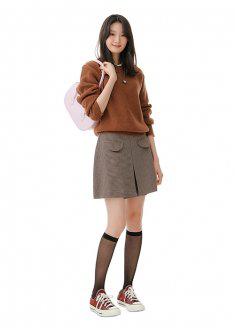

In [23]:
example[5][0]

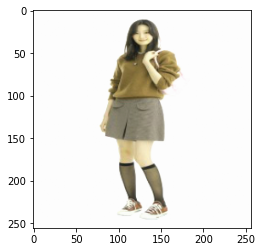

In [22]:
show_img(train_set[5][0])

In [26]:
from torch.utils.data import Dataset, DataLoader                                # 데이터 커스터마이징
from PIL import Image                                                           # PIL = Python Image Library
import cv2                                                                      # albumentation transform을 쓰려면 꼭 이 라이브러리를 이용
import tensorflow as tf

data_path = '/content/drive/MyDrive/스타일'

class Custom_Dataset(Dataset):

  def __init__(self, file_path, mode, transform=None):
    self.all_data = sorted(glob.glob(os.path.join(file_path, mode, '*', '*')))
    self.transform = transform

  def __getitem__(self, index):
    # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔준다.
    if torch.is_tensor(index):        
       index = index.tolist()

    data_path = self.all_data[index]
    #img = np.array(Image.open(data_path).convert("RGB")) # albumenatation transform을 쓰려면 cv2 라이브러리로 이미지를 읽어야 함
    image=cv2.imread(data_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                                # BGR -> RGB 변환

    # transform 적용
    if self.transform is not None:    
       augmented = self.transform(image=image)
       image = augmented['image'] 

    # 이미지 라벨 ['걸리시', '댄디', '로맨틱', '스트릿', '스포츠', '캐주얼', '포멀']
    label=[]                                
    for i, name in enumerate(class_names):
      if os.path.basename(data_path).startswith(name) == True:                  
          label = i
      
    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

In [ ]:
Image.open(Custom_Dataset(data_path, "train", transform = None).all_data[0])

In [ ]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 
        # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        #x.shape =[256, 32, 32]
        x = self.layer3(x)
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 8, True).to(device) 
# resnet50
# 1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                         shuffle=False, num_workers=0)

In [ ]:
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

In [ ]:
lr = 0.0008
epochs = 30
optimizer = 'Adam'

In [ ]:
# 파라미터 클래스
config = Config(
    trainloader = trainloader,
    testloader = testloader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [ ]:
class train_test():
      def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(trainloader))
      def train(self, epochs, log_interval):
          self.model.train()
          for epoch in range(1, epochs + 1 ):  # epochs 루프
              running_loss = 0.0
              lr_sche.step()
              for i, data in enumerate(self.trainloader, 0): # batch 루프
                  # get the inputs
                  self.globaliter += 1
                  inputs, labels = data # input data, label 분리
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)

                  # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                  self.optimizer.zero_grad() 

                  # forward + backward + optimize
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  self.optimizer.step()
                  running_loss += loss.item()

                  # 30 iteration마다 acc & loss 출력
                  if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0

                    #with train_summary_writer.as_default():
                    #    summary.scalar('loss', loss.item() , step = self.globaliter)

              with torch.no_grad():
                  self.model.eval()
                  correct = 0
                  total = 0
                  test_loss = 0
                  acc = []
                  for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)

                  print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                      test_loss, correct, total, 100 * correct/total
                  ))
                  #with test_summary_writer.as_default():
                  #    summary.scalar('loss', test_loss , step = self.globaliter)
                  #    summary.scalar('accuracy', 100 * correct/total , step = self.globaliter)  
##                      if acc [k] > 60 and acc[k] > acc[k-1]:
#                         torch.save({
#                                     'epoch': epoch,
#                                     'model_state_dict': self.model.state_dict(),
#                                     'optimizer_state_dict': self.optimizer.state_dict(),
#                                     'loss': test_loss
#                                     }, PATH)
                         
      print('Finished Training')

Finished Training


In [ ]:
ready_to_train=train_test(config)

186


In [ ]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=10000, gamma=0.5) # 20 step마다 lr조정
epochs = 10
log_interval = 175

ready_to_train.train(epochs, log_interval)

# pytorch tutorial

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/스타일/output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


In [ ]:
class_names

['걸리시', '댄디', '로맨틱', '스트릿', '스포츠', '캐주얼', '포멀']

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),                                              # 이미지 resize
    transforms.RandomCrop(256),                                                 # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1),                                     # p확률로 이미지 좌우반전
                                       
    transforms.ToTensor()
    ])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor()
    ])

train_set = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)

test_set = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=False, num_workers=0)

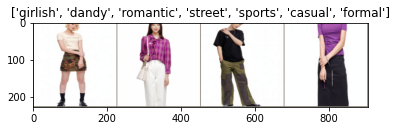

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=["girlish", 'dandy', 'romantic', 'street', 'sports', 'casual', 'formal'])